# Financial Mathematics 
### Lab 01: Pseudorandom number generators

The purpose of the tasks below is to implement variety of pseudorandom number generators. All written generators base on linear pseudo-random number generator and do not use built-in generators.

### Libraries 

In [1]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.special import erfinv

### Tasks

(a) Linear random number generator from U([0,1]) distribution.

In [4]:
def linear_generator(a0: float, a1: float, m: int, N: int, seed: int = None) -> list:
    """
        Generates a sequence of pseudo-random numbers using a linear congruential generator (LCG) algorithm.
        References: https://en.wikipedia.org/wiki/Linear_congruential_generator

        Args:
            a0 (float): The initial seed value.
            a1 (float): The multiplier.
            m (int): The modulus.
            N (int): The number of random numbers to generate.

        Returns:
            np.ndarray: Array of pseudo-random numbers in the range [0, 1).
        """
        
    if seed is None:
        seed = int(time.time())
        
    x = []
    for i in range(N+1):
        if i == 0:
            x.append(seed)
        else:
            x_n = (a0 + a1 * x[-1]) % m
            x.append(x_n)
    res = [i/m for i in x]
    return res[1:]

def pseudo_rng(N: int, seed: int = None) -> np.array:
    """
        Generates pseudo-random numbers using a linear congruential generator (LCG) algorithm.

        Args:
            N (int): Number of random numbers to generate.
            seed (int): Seed for the random number generator.

        Returns:
            np.ndarray: Array of pseudo-random numbers in the range [0, 1).
    """
    a0 = np.floor(10**9 * np.exp(1))
    a1 = np.floor(10**9 * np.pi)
    m = 2**35
    
    generated_numbers = linear_generator(a0, a1, m, N, seed=seed)
    return np.array(generated_numbers)

Example usage:

In [5]:
pseudo_rng(10)

array([0.89296654, 0.33233261, 0.41286409, 0.80720854, 0.67289066,
       0.69393969, 0.68116951, 0.78990698, 0.62485027, 0.37666559])

Results visualization on histogram.

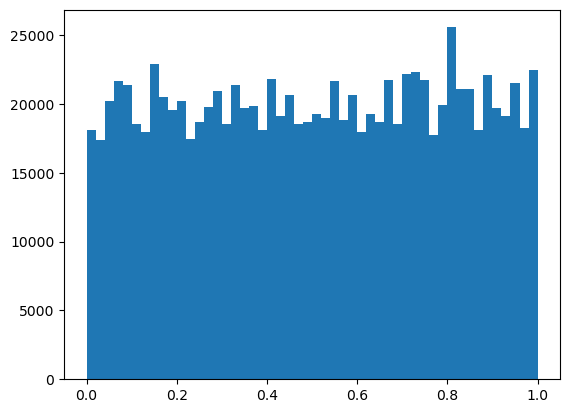

In [4]:
plt.hist(pseudo_rng(10**6), bins=50);

As we can observe, the distribution does not look like uniform.

Text(0.5, 1.0, 'linear generator')

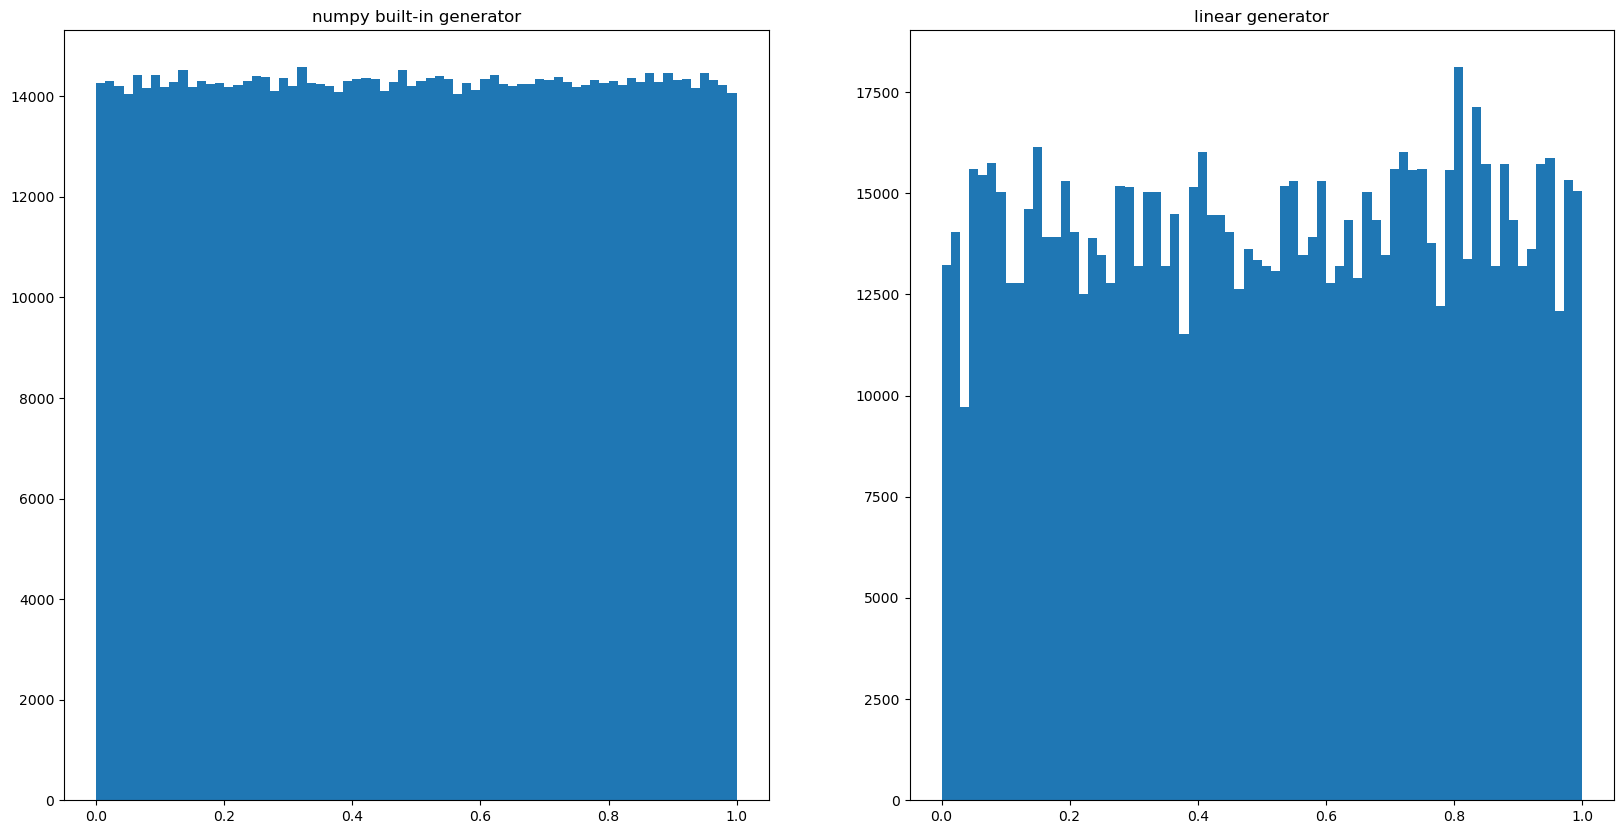

In [5]:
sample_1 = np.random.uniform(0,1,1000_000)
sample_2 = pseudo_rng(1000_000, seed=7312)

plt.figure(figsize=(20,10))

plt.subplot(121)
plt.hist(sample_1, bins=70)
plt.title('numpy built-in generator')

plt.subplot(122)
plt.hist(sample_2, bins=70)
plt.title('linear generator')

Our suspisions were justified. Let's perform statistical test in order to formally proove the difference. Kolmogorov-Smirnov test with p_value=0.05 will be used.

In [6]:
stats.kstest(sample_1, sample_2)

KstestResult(statistic=0.013475999999999932, pvalue=2.660622807639249e-79, statistic_location=0.6592626675928901, statistic_sign=1)

With p-value=1.78e-90, it can be concluded that the sample received with linear generator is not uniform. 

(b) We will sample from distribution given with pdf:

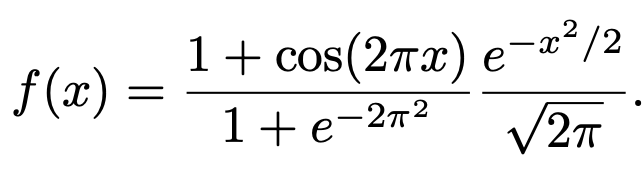

In [7]:
def crazy_density(x: float) -> float:
    """
        Computes the density function of a crazy distribution.
        
        Args:
            x (float): The value at which to compute the density function.
        
        Returns:
            float: The density function evaluated at x.
    """
    return ((1 + np.cos(2 * np.pi * x)) * np.exp( (-1) * x**2 * 0.5))/((1 + np.exp(-2 * np.pi**2)) * np.sqrt(2 * np.pi))

def standard_normal_density(x: float) -> float:
    """
        Computes the density function of a standard normal distribution.
        
        Args:
            x (float): The value at which to compute the density function.
            
        Returns:
            float: The density function evaluated at x.
    """
    return np.exp( (-1) * x**2 * 0.5) / np.sqrt(2 * np.pi)

Since the density is unbounded on X axis, we cannot use elimination method, therefore we will utilize the modified elimination method. Second part of the density f i pdf of N(0,1), while the first part is bounded - reaches values from [0,2] interval (see plot below). Therefore 

crazy_density(x) <= 2 * f_normal(x) for all x

In order to sample from normal distribution, we will implement our own generator, using method of inverting the distribution function.

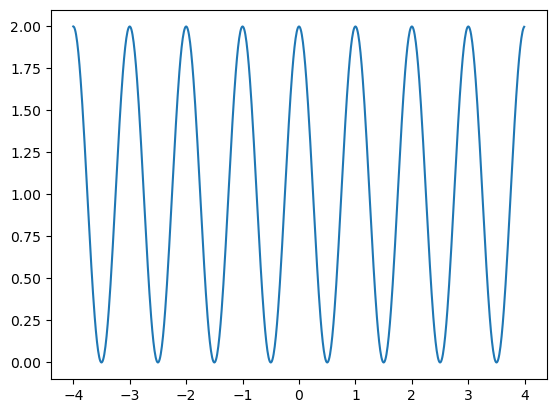

In [61]:
x = np.arange(-4, 4, 0.01)
y = [(1 + np.cos(2 * np.pi * i))/(1 + np.exp(-2 * np.pi**2)) for i in x]
plt.plot(x, y);

In [118]:
def standard_normal_generator(seed: int = None) -> float:
    """
        Generates a random sample from the standard normal distribution using the inverse transform sampling method.
        References for cdf inversion: https://en.wikipedia.org/wiki/Normal_distribution

        Args:
            seed (int): Seed for the random number generator.

        Returns:
            float: A random sample from the standard normal distribution.
    """
    u = np.array(pseudo_rng(1, seed))
    return np.sqrt(2) * erfinv(2 * u - 1)

Example:

In [9]:
standard_normal_generator(seed=2137)

array([-0.07499753])

In [210]:
def modified_elimination_method(a: float, seed: int = None) -> float:
    """
        Generates a random sample from a given (crazy_density) distribution using the modified elimination method.

        Args:
            a (float): The scaling factor for the density function.

        Returns:
            float: A random sample from the distribution.
    """
    y = pseudo_rng(1, seed)
    x = standard_normal_generator()
    
    while y <= (crazy_density(x)/(a*standard_normal_density(x))):
        y = pseudo_rng(1)
        x = standard_normal_generator()

    return x

Example:

In [211]:
modified_elimination_method(a = 2)

array([0.5686156])

(c) Let's sample from Poisson distibution. 

**First method: using sampling algorithm for discrete distributions.**

In [34]:
def poisson_probability(lambd: float , k: int) -> float:
    """
        Computes the probability of k events occurring in a fixed interval of time or space.

        Args:
            lambd (float): The average number of events in the interval.
            k (int): The number of events.

        Returns:
            float: The probability of k events occurring in the interval.
    """
    
    return lambd**k / math.factorial(k) * np.exp(-lambd)

In [32]:
def poisson_generator(lambd: float = 1, n_samples: int = 1, seed: int = None) -> list:
    """
        Generates random samples from a Poisson distribution using the inverse transform sampling method.

        Args:
            lambd (float): The average number of events in the interval.
            n_samples (int): The number of samples to generate.
            seed (int): Seed for the random number generator.

        Returns:
            list: A list of random samples
    """
    
    res = []
    u = pseudo_rng(n_samples, seed)

    for j in range(n_samples):
        i = 0
        poisson_cdf_at_i = poisson_probability(lambd, i)

        while u[j] > poisson_cdf_at_i:
            i += 1
            poisson_cdf_at_i += poisson_probability(lambd, i)

        res.append(i)
        
    return res

In [14]:
poisson_generator(lambd = 1, n_samples=21, seed = 1)

[0, 0, 0, 0, 0, 1, 0, 2, 3, 2, 1, 2, 2, 0, 1, 0, 2, 0, 0, 2, 1]

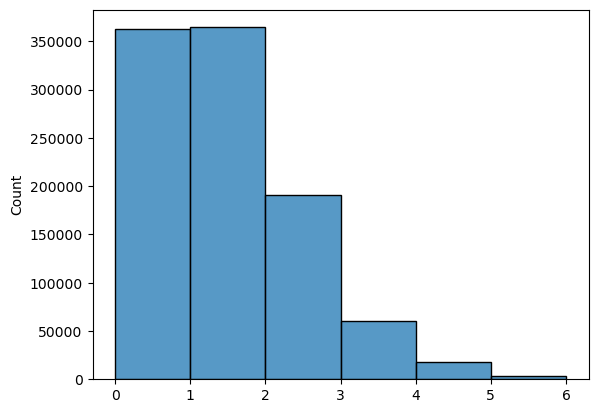

In [15]:
sns.histplot(poisson_generator(lambd = 1, n_samples=10**6, seed = 1), binwidth=1);

Text(0.5, 1.0, 'poisson generator')

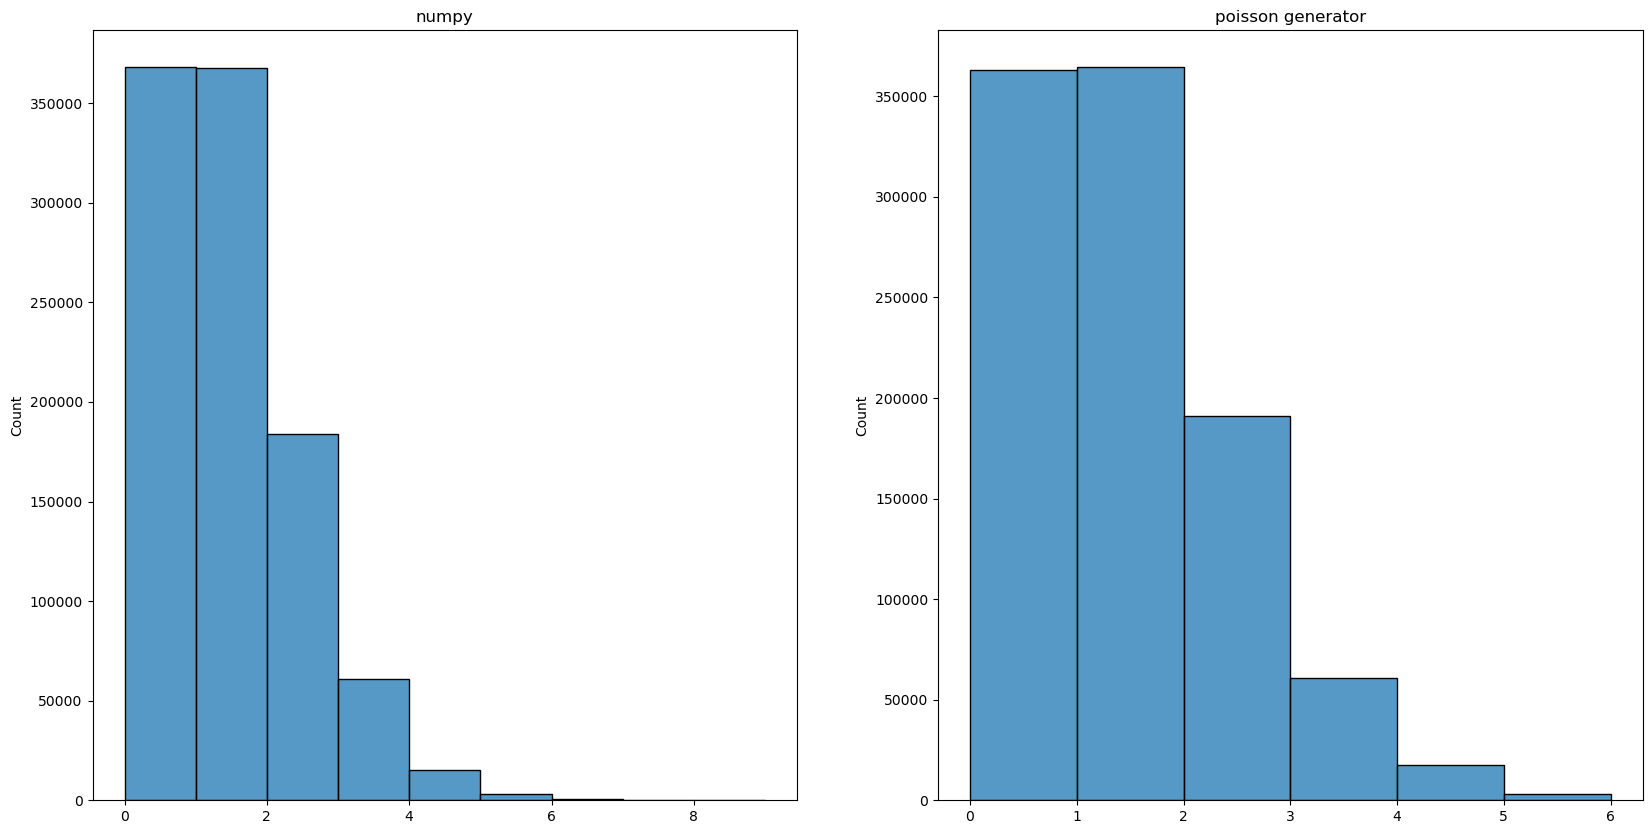

In [55]:
sample_1 = np.random.poisson(1, 10**6)
sample_2 = poisson_generator(lambd = 1, n_samples=10**6, seed = 1)

plt.figure(figsize=(20,10))
plt.subplot(121)
sns.histplot(sample_1, binwidth=1, kde=False)
plt.title('numpy')
plt.subplot(122)
sns.histplot(sample_2, binwidth=1, kde=False)
plt.title('poisson generator')

At first glance, they look similiar. However, our generators' results give more bigger values. Let's test samples' difference using Kolmogorov-Smirnov test and p = 0.05.

In [17]:
stats.kstest(sample_1, sample_2)

KstestResult(statistic=0.008184999999999998, pvalue=1.5959440633806922e-29, statistic_location=1, statistic_sign=1)

With pvalue < 0.05, we reject the null hypothesis that the two distributions are the same.

**Second method: Poissons' process' construction theorem**

In [6]:
def exponential_generator(n_samples: int = 1, lambd: float = 1, seed: int = None) -> list:
    u = pseudo_rng(n_samples, seed)
    return -np.log(1-u)/lambd

Firstly, let's test the quality exponential generator.

Text(0.5, 1.0, 'exponential generator')

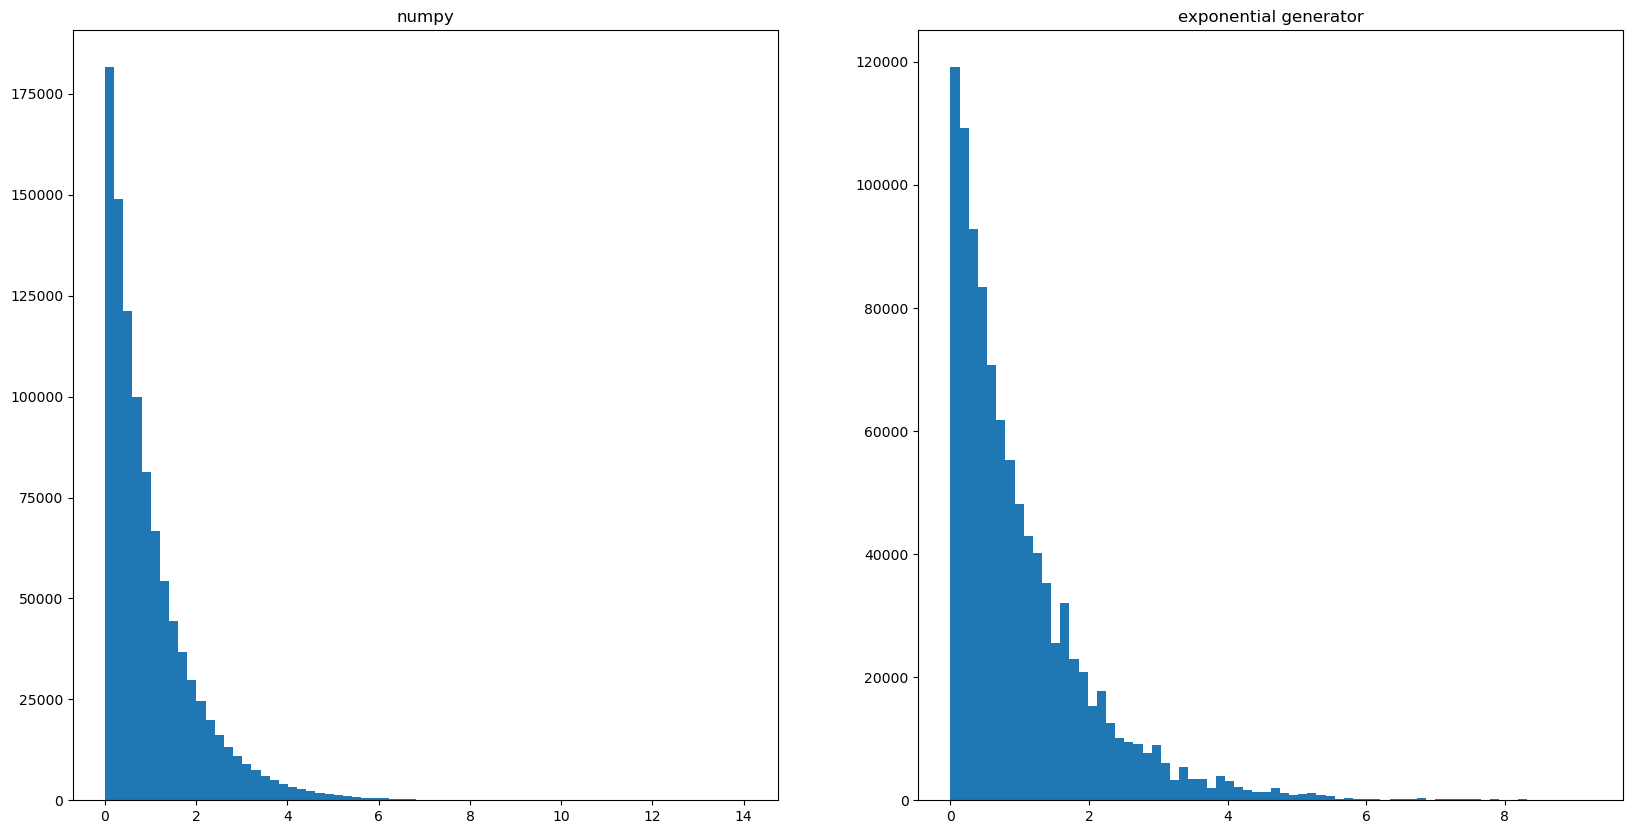

In [189]:
sample_1 = np.random.exponential(1, 10**6)
sample_2 = exponential_generator(10**6, 1, 1)

plt.figure(figsize=(20,10))

plt.subplot(121)
plt.hist(sample_1, bins=70)
plt.title('numpy')
plt.subplot(122)
plt.hist(sample_2, bins=70)
plt.title('exponential generator')


At first glance, they look similiar. However, our generators' results give more bigger values. Let's test samples' difference using Kolmogorov-Smirnov test and p = 0.05. 

In [190]:
stats.kstest(sample_1, sample_2)

KstestResult(statistic=0.013786999999999994, pvalue=5.524559864825499e-83, statistic_location=1.0766459501503092, statistic_sign=1)

With pvalue=4.6e-75, we conclude that there is significant difference between distribuitions.

In [29]:
def poisson_generator_2(lambd: float = 1, n_samples: int = 1, seed: int = None) -> list:
    res = []
    for _ in range(n_samples):
        k = 0
        ksi = exponential_generator(1, lambd, seed)
        t = ksi 
        while t < 1:
            ksi = exponential_generator(1, lambd, seed)
            t += ksi
            k += 1  
        res.append(k)
            
    return res

In [30]:
poisson_generator_2(1, n_samples=2)

[0, 0]

Text(0.5, 1.0, 'poisson generator')

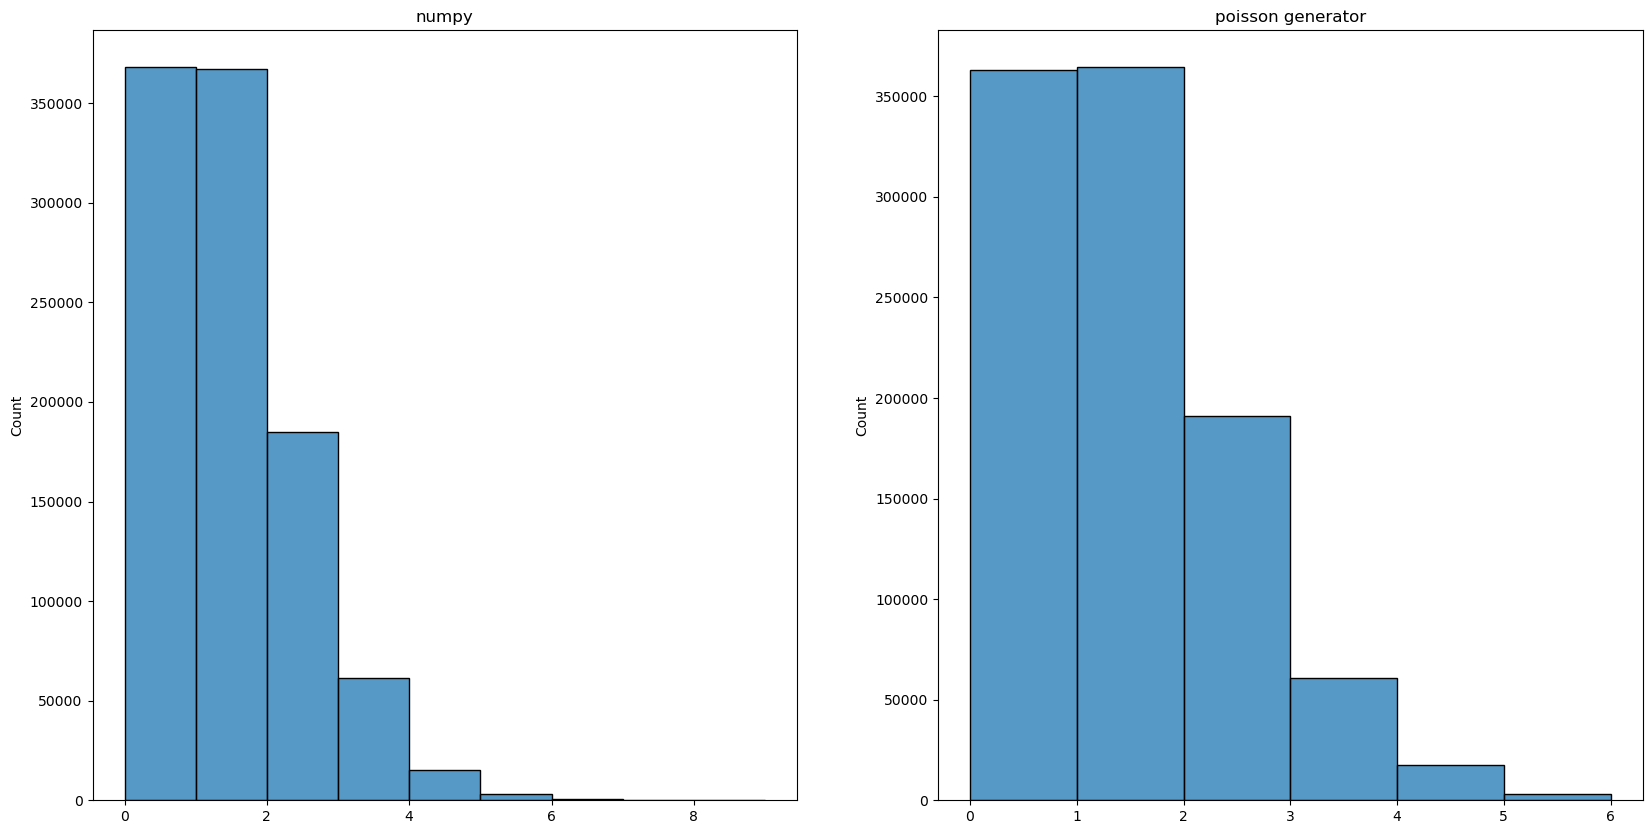

In [35]:
sample_1 = np.random.poisson(1, 10**6)
sample_2 = poisson_generator(lambd = 1, n_samples=10**6, seed = 1)

plt.figure(figsize=(20,10))
plt.subplot(121)
sns.histplot(sample_1, binwidth=1, kde=False)
plt.title('numpy')
plt.subplot(122)
sns.histplot(sample_2, binwidth=1, kde=False)
plt.title('poisson generator')

They look similiar.

(c')

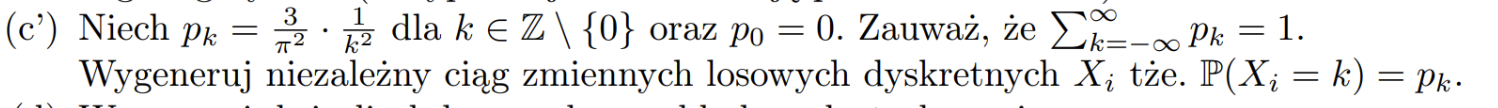

In [18]:
def c_probability(k: int) -> float:
    return 3 / np.pi**2 / k**2

In [ ]:
def c_generator(n_samples: int, seed: int = None) -> list:
    res = []
    u = pseudo_rng(n_samples, seed)

    for j in range(n_samples):
        i = 1 
        c_cdf_at_i = 2 * c_probability(i)

        while u[j] > c_cdf_at_i:
            i += 1
            c_cdf_at_i += 2 * c_probability(i)

        res.append(i) if np.random.uniform(0,1) < 0.5 else res.append(-i)

    return res

In [20]:
c_generator(20)

[-1, -13, -1, -9, -1, -1, -3, -3, 1, -6, -1, -2, 4, -1, 1, 1, -2, -1, -2, 1]

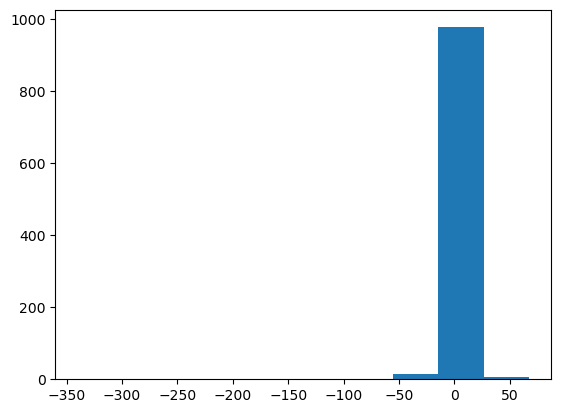

In [21]:
c = c_generator(1000)
plt.hist(c);

This distribution does not have mean, however its median is 0. Let's visualize cummulative means.

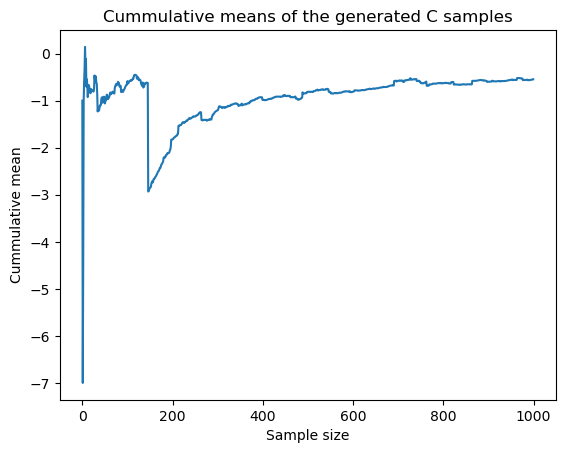

In [56]:
c_cummulative_sums = np.cumsum(c)
c_cummulative_means = [0 for _ in range(len(c_cummulative_sums))]

for i in range(len(c_cummulative_sums)):
    c_cummulative_means[i] = c_cummulative_sums[i]/(i+1)

plt.plot(c_cummulative_means)
plt.title("Cummulative means of the generated C samples")
plt.xlabel("Sample size")
plt.ylabel("Cummulative mean")
plt.show()

(d) Sample from 
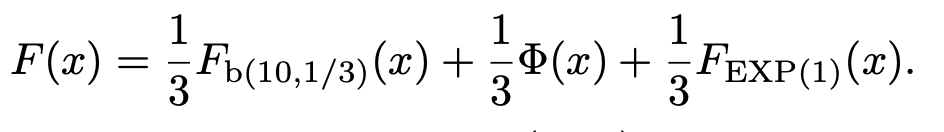

With probability 1/3 we sample from either bin(10, 1/3), N(0,1) or EXP(1). 

Let's implement binomial generator.

In [26]:
def binomial_probability(n: int, p: int, k: int) -> float:
    return math.comb(n, k) * p**k * (1-p)**(n-k)

In [ ]:
def binomial_generator(n: int, p: float, n_samples: int = 1, seed: int = None):
    res = []
    u = pseudo_rng(n_samples, seed)

    for j in range(n_samples):
        i = 0
        binomial_cdf_at_i = binomial_probability(n = n, p = p, k = i)

        while u[j] > binomial_cdf_at_i:
            i += 1
            binomial_cdf_at_i += binomial_probability(n = n, p = p, k = i)

        res.append(i)
    
    return res

Text(0.5, 1.0, 'binomial generator')

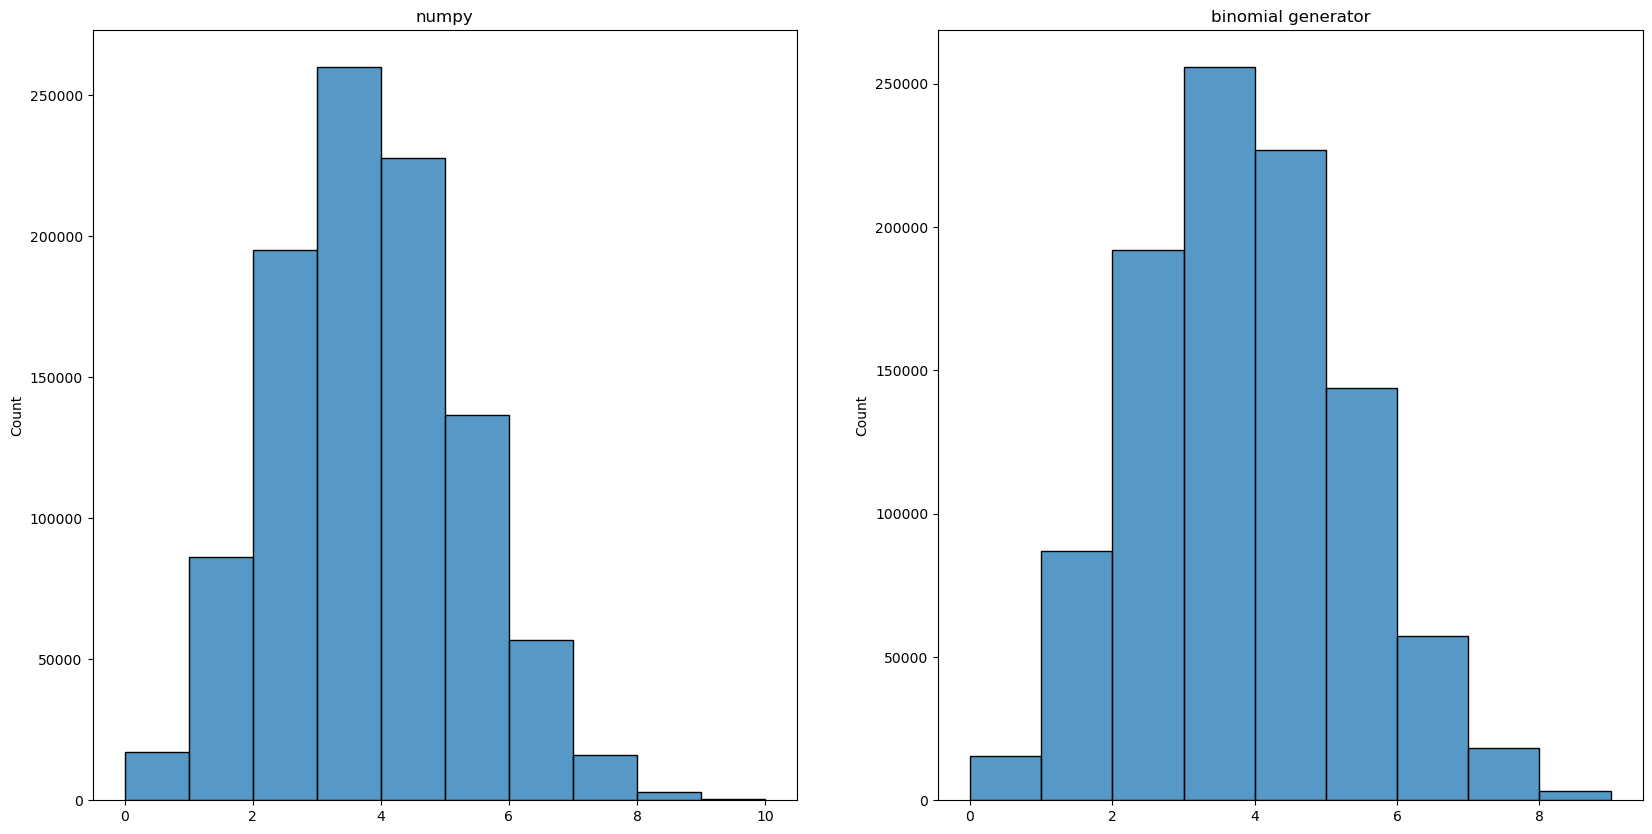

In [58]:
sample_1 = np.random.binomial(10, 1/3, 10**6)
sample_2 = binomial_generator(n = 10, p = 1/3, n_samples=10**6, seed = 1)

plt.figure(figsize=(20,10))

plt.subplot(121)
sns.histplot(sample_1, binwidth=1)
plt.title('numpy')
plt.subplot(122)
sns.histplot(sample_2, binwidth=1)
plt.title('binomial generator')


Those histogram look very much alike. Similarily to previous generators, we will compare those two distribuition using KS test and p = 0.05.

In [29]:
stats.kstest(sample_1, sample_2)

KstestResult(statistic=0.010222000000000064, pvalue=8.27784480022394e-46, statistic_location=4, statistic_sign=1)

Again, distributions are significantly different. (Although at first glance, they look super-similar.)

Let's get back to the mixture distribution.

In [ ]:
def mixture_generator(n_samples: int, seed: int = None) -> list:
    u = pseudo_rng(n_samples, seed=seed)
    res = []
    
    for j in range(n_samples):
        if u[j] < 1/3:
            res.append(binomial_generator(10, 1/3, seed=seed))
        
        elif u[j] < 2/3:
            res.append(standard_normal_generator(seed=seed))
        
        else:
            res.append(exponential_generator(lambd = 1, seed=seed))
            
        if seed is not None:
            seed += 1
        else:
            seed = 0 
    res = [item for sublist in res for item in sublist]
    return res

In [111]:
def ecdf(sample, x):
    t = np.sort(sample)
    return sum(i <= x for i in t)/len(t)

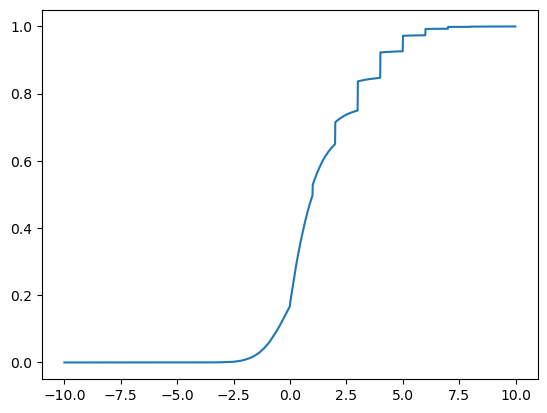

In [137]:
sample = mixture_generator(n_samples=10_000)
x = np.arange(-10, 10, 0.01)
ecdfs = [ecdf(sample, i) for i in x]

plt.plot(x, ecdfs)

Let's compare the result with the "theoretical" (as well as samples received using built-in generators) cdf.

In [94]:
def mixture_generator_builtin(n_samples: int) -> list:
    u = np.random.uniform(0, 1, n_samples)
    res = []

    for j in range(n_samples):
        if u[j] < 1/3:
            res.append(np.random.binomial(10, 1/3))
        
        elif u[j] < 2/3:
            res.append(np.random.normal(0, 1))
        
        else:
            res.append(np.random.exponential(1))
    
    return res

In [95]:
def binomial_cdf(x, n, p):
    if x < 0:
        return 0
    res = 0
    for i in range(int(x) + 1):
        res += binomial_probability(n, p, i)
    return res

def exponential_cdf(x, lambd):
    if x <= 0:
        return 0 
    return 1 - np.exp(-lambd * x)

def normal_cdf(x, mu, sigma):
    return 0.5 * (1 + math.erf((x - mu)/(sigma * np.sqrt(2))))

def F(x, n, p, lambd, mu, sigma):
    return 1/3 * binomial_cdf(x, n, p) + 1/3 * exponential_cdf(x, lambd) + 1/3 * normal_cdf(x, mu, sigma)

<Axes: >

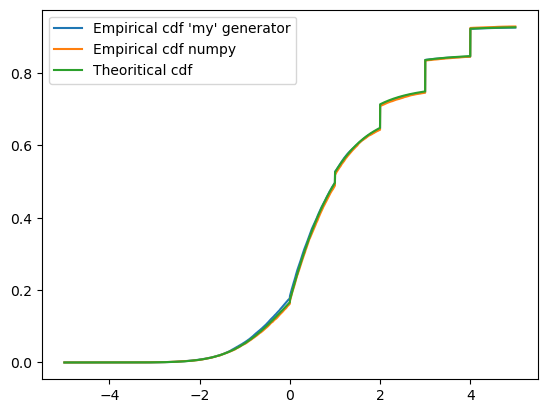

In [138]:
sample_1 = mixture_generator(n_samples = 20_000)
sample_2 = mixture_generator_builtin(n_samples = 20_000)
x = np.arange(-5, 5, 0.001)

ecdf_1 = [ecdf(sample_1, i) for i in x]
ecdf_2 = [ecdf(sample_2, i) for i in x]
theoritical = [F(i, 10, 1/3, 1, 0, 1) for i in x]


sns.lineplot(x = x, y = ecdf_1, label = "Empirical cdf 'my' generator")
sns.lineplot(x = x, y = ecdf_2, label = "Empirical cdf numpy")
sns.lineplot(x = x, y = theoritical, label = "Theoritical cdf")


Nice. Suspiciously nice.

(e) Implementation of other algorithms.

**JKISS**

In [ ]:
x, y, z, c = 123456789, 987654321, 43219876, 6543217

def jkiss():
    global x, y, z, c
    
    x = (314527869 * x + 1234567) % (2**32)  
    y = (y * 32 + y // 128 + y * (2**22)) % (2**32)

    t = 4294584393 * z + c
    c = (t // (2**32)) % (2**32)
    z = t % (2**32)

    res = (x + y + z) % (2**32)  

    return res/ 4294967296.0

In [143]:
for _ in range(4):
    print(jkiss())

0.004981696140021086
0.5012678203638643
0.7258244373369962
0.9138404047116637


Text(0.5, 1.0, 'jkiss generator')

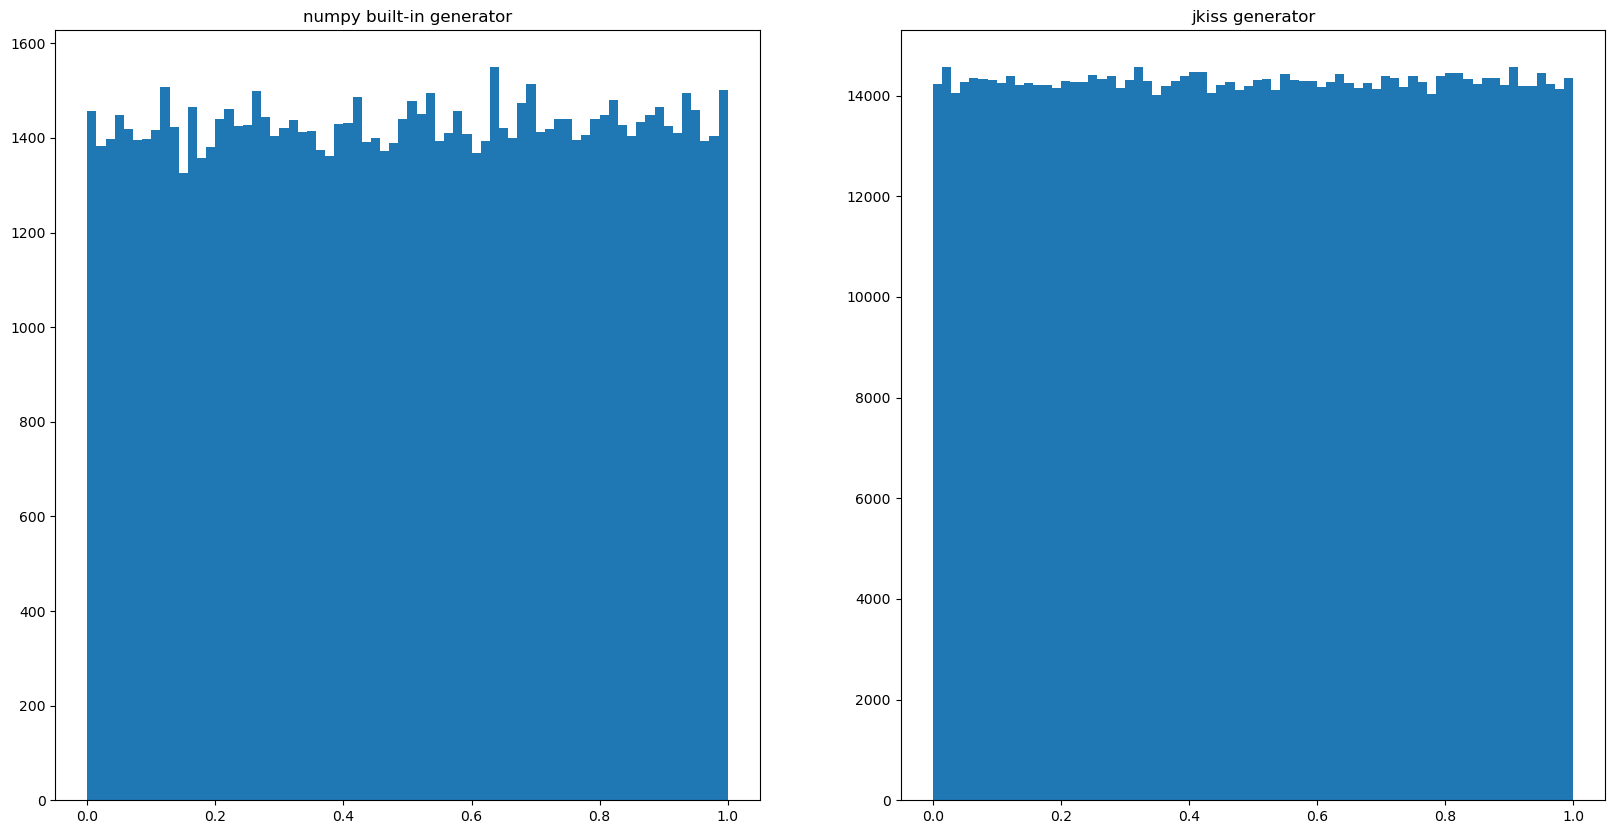

In [145]:
sample_1 = [None] * 100_000
for i in range(100_000):
    sample_1[i] = jkiss()
    
sample_2 = np.random.uniform(0,1,1000_000)

plt.figure(figsize=(20,10))

plt.subplot(121)
plt.hist(sample_1, bins=70)
plt.title('numpy built-in generator')

plt.subplot(122)
plt.hist(sample_2, bins=70)
plt.title('jkiss generator')

Those histograms look very much alike. Let's perform the Kolmogorow-Smirnov test with p = 0.05.

In [146]:
stats.kstest(sample_1, sample_2)

KstestResult(statistic=0.003888999999999976, pvalue=0.12750736530471607, statistic_location=0.4876729386546813, statistic_sign=-1)

JKISS' sampling seems to be great compared to linear generator.

Below, I present an alternative solution - with Python bit shifts (*achieved using ChatGPT*).

In [151]:
x, y, z, c = 123456789, 987654321, 43219876, 6543217

def jkiss_2():
    global x, y, z, c
    # Update x using a linear congruential method
    x = (314527869 * x + 1234567) & 0xFFFFFFFF  # Keep it 32-bit

    # Update y using XOR-shift
    y ^= (y << 5) & 0xFFFFFFFF
    y ^= (y >> 7) & 0xFFFFFFFF
    y ^= (y << 22) & 0xFFFFFFFF

    # Multiply-with-carry for z, c
    t = 4294584393 * z + c
    c = (t >> 32) & 0xFFFFFFFF  # Extract upper 32 bits
    z = t & 0xFFFFFFFF          # Extract lower 32 bits

    res = (x + y + z) & 0xFFFFFFFF  # Keep it 32-bit
    return res / 4294967296.0  # Normalize

In [152]:
jkiss_2()

0.13044139207340777

#### Execution time

Now, let's compare execution time generating 1 000 000 samples of U([0,1]) using 5 algorithms:
- built-in numpy
- our linear generator
- jkiss
- jkiss (second version)

In [160]:
t0 = time.time()
for _ in range(1_000_000):
    np.random.uniform(0,1)
t1 = time.time()
print(f"Elapsed for NumPy: {t1 - t0}")

Elapsed for NumPy: 0.8066952228546143


In [161]:
t0 = time.time()
for _ in range(1_000_000):
    pseudo_rng(1)
t1 = time.time()
print(f"Elapsed for our linear: {t1 - t0}")

Elapsed for our linear: 1.6112632751464844


In [162]:
t0 = time.time()
for _ in range(1_000_000):
    jkiss()
t1 = time.time()
print(f"Elapsed for JKISS: {t1 - t0}")

Elapsed for JKISS: 0.5244371891021729


In [163]:
t0 = time.time()
for _ in range(1_000_000):
    jkiss_2()
t1 = time.time()
print(f"Elapsed for JKISS (with bits' shift): {t1 - t0}")

Elapsed for JKISS (with bits' shift): 0.5332961082458496


Results:
| algorithm | time |
| --------- | ----- |
| NumPy | 0.81 |
| linear | 1.61 |
| jkiss | 0.52 |
| jkiss_2 | 0.53 |


Udoubtedly, linear generator is not fast. The JKISS seems to be great in both quality and execution time categories.

Let's examine, if improvements in jkiss_2 really improve time consumption. Again, with KS test and p = 0.05.

In [171]:
times_1 = []
times_2 = []

for _ in range(1000):
    t0 = time.time()
    for _ in range(10000):
        jkiss()
    t1 = time.time()
    times_1.append(t1-t0)
    t2 = time.time()
    for _ in range(10000):
        jkiss()
    t3 = time.time()
    times_2.append(t3-t2)

In [172]:
stats.kstest(times_1, times_2)

KstestResult(statistic=0.038, pvalue=0.4659595288557257, statistic_location=0.004827022552490234, statistic_sign=-1)

We can conclude that there is no significant difference between times of execution.

## Conclusions 

- linear generator is a method that is far from ideal: all statistical tests have proved that samples (our and numpy generator's) come from different distributions;
- one may say that built-in generators do not provide pure-randomness, however their histograms do look as the theory preeches, indeed they result way better than our linear-based generators;
- jkiss algorithm appears to be an excellent solution: it is both of a good quality and executes in short time, however built-in NumPy solution is not bad either;
- note that: in tasks above some conclusions assume that built-it numpy generators are working well.